In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

# Custom loader to handle corrupted images
def safe_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except UnidentifiedImageError:
        print(f"Skipping corrupted image: {path}")
        return None

train_dir = '/home/arnav/Documents/research_project/assignment01/images/train'
test_dir = '/home/arnav/Documents/research_project/assignment01/images/test'
val_dir = '/home/arnav/Documents/research_project/assignment01/images/val'

transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor(), #Convert a PIL Image or ndarray to tensor and scale the values accordingly, this transformation scales the pixel values from the range [0, 255] to the range [0, 1].
                               transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]) #Normalize a tensor image with mean and standard deviation. Mean normalization: Subtracts the mean value from each channel (R, G, B) of the image tensor.Standard deviation normalization: Divides each channel by its standard deviation.

train_data = datasets.ImageFolder(root= train_dir, transform=transform, loader= safe_loader)
test_data = datasets.ImageFolder(root= test_dir, transform=transform, loader = safe_loader)
val_data = datasets.ImageFolder(root= val_dir, transform=transform, loader = safe_loader)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


/home/arnav/anaconda3/envs/research_project/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.l1 = nn.Linear(64*64*3, 256) # Input: 12288, Output: 256
        self.l2 = nn.Linear(256, 128)          # Input: 256, Output: 128
        self.l3 = nn.Linear(128, 64)           # Input: 128, Output: 64
        self.relu = nn.ReLU() #Rectified Linear Units: activation function. simply returns max(0,x)

    def forward(self, x):
        x= x.view(x.size(0), -1) # reshapes the input tensor to have the shape (batch_size, num_features), where num_features is the product of the dimensions of the image.
        x = self.relu(self.l1(x)) #pass the flattened input through first layer
        x = self.relu(self.l2(x))
        x = self.l3(x) # passes the output of the second layer through the third fully connected layer, This layer does not have an activation function applied, as it directly outputs the raw scores (logits) for the two classes (cat and fish)

        return x  

# from torchvision.models import alexnet

# class CustomAlexNet(nn.Module):
#     def __init__(self):
#         super(CustomAlexNet, self).__init__()
#         self.alexnet = alexnet(pretrained=False)
#         self.alexnet.classifier[6] = nn.Linear(4096, 2)#replaced the 6th and final layer of the alexnet classifier with a layer that outputs 2 classes (cat and fish)
        
#     def forward(self, x):
#         return self.alexnet(x)




def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=25, device="cpu"):
    model.to(device)
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        
        model.train()  # Setting the model to train mode
        training_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Set gradient to zero
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)
            loss.backward()  # Backward pass
            optimizer.step()
            training_loss += loss.item()  # Loss.item() converts the loss tensor to a standard Python number (float)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(training_loss / len(train_loader))

        model.eval()  # Setting the model to validation mode
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation during validation, which saves memory and computation time
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch}: Train Loss: {training_loss / len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss / len(val_loader)}, Val Accuracy: {val_accuracy}")

    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f"Average Training Accuracy over {epochs} epochs: {avg_train_accuracy}")
    print(f"Average Validation Accuracy over {epochs} epochs: {avg_val_accuracy}")

    # Plotting accuracies and losses
    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs_range, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs_range, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def test(model, test_loader, device="cpu"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {accuracy}")


Epoch 1: Train Loss: 2.1865611644018266, Train Accuracy: 0.6276595744680851, Val Loss: 1.0171967971892584, Val Accuracy: 0.7583586626139818
Epoch 2: Train Loss: 0.7877770775840396, Train Accuracy: 0.7735562310030395, Val Loss: 0.5545759967395237, Val Accuracy: 0.8282674772036475
Epoch 3: Train Loss: 0.5048964470624924, Train Accuracy: 0.8161094224924013, Val Loss: 0.3748488241717929, Val Accuracy: 0.8829787234042553
Epoch 4: Train Loss: 0.3591757679269427, Train Accuracy: 0.8829787234042553, Val Loss: 0.28158235975674223, Val Accuracy: 0.9164133738601824
Epoch 5: Train Loss: 0.29587316867851077, Train Accuracy: 0.9103343465045592, Val Loss: 0.2361576823251588, Val Accuracy: 0.9285714285714286
Epoch 6: Train Loss: 0.23145810904956998, Train Accuracy: 0.9376899696048632, Val Loss: 0.19666703932342075, Val Accuracy: 0.9452887537993921
Epoch 7: Train Loss: 0.22069086311828523, Train Accuracy: 0.9331306990881459, Val Loss: 0.16852388176180066, Val Accuracy: 0.9452887537993921
Epoch 8: Train

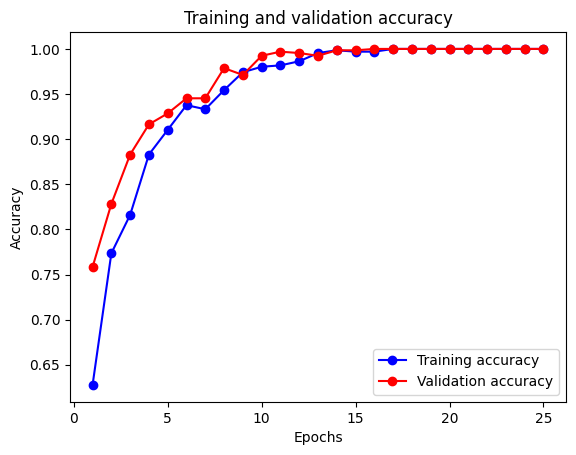

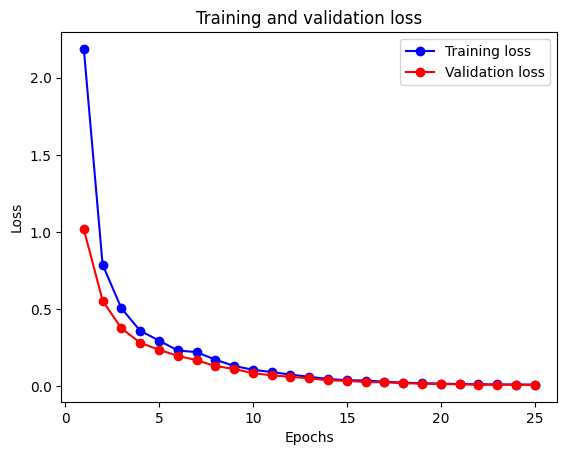

Test Loss: 0.8461626414209604, Test Accuracy: 0.7730061349693251


In [3]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)


In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.l1 = nn.Linear(3 * 64 * 64, 512)   # Input: 12288, Output: 512
        self.l2 = nn.Linear(512, 256)           # Input: 512, Output: 256
        self.l3 = nn.Linear(256, 128)           # Input: 256, Output: 128
        self.relu = nn.ReLU() #Rectified Linear Units: activation function. simply returns max(0,x)

    def forward(self, x):
        x= x.view(x.size(0), -1) # reshapes the input tensor to have the shape (batch_size, num_features), where num_features is the product of the dimensions of the image.
        x = self.relu(self.l1(x)) #pass the flattened input through first layer
        x = self.relu(self.l2(x))
        x = self.l3(x) # passes the output of the second layer through the third fully connected layer, This layer does not have an activation function applied, as it directly outputs the raw scores (logits) for the two classes (cat and fish)

        return x  


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=25, device="cpu"):
    model.to(device)
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        
        model.train()  # Setting the model to train mode
        training_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Set gradient to zero
            outputs = model(inputs)  # Forward pass
            loss = loss_fn(outputs, targets)
            loss.backward()  # Backward pass
            optimizer.step()
            training_loss += loss.item()  # Loss.item() converts the loss tensor to a standard Python number (float)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(training_loss / len(train_loader))

        model.eval()  # Setting the model to validation mode
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation during validation, which saves memory and computation time
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch}: Train Loss: {training_loss / len(train_loader)}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss / len(val_loader)}, Val Accuracy: {val_accuracy}")

    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f"Average Training Accuracy over {epochs} epochs: {avg_train_accuracy}")
    print(f"Average Validation Accuracy over {epochs} epochs: {avg_val_accuracy}")

    # Plotting accuracies and losses
    import matplotlib.pyplot as plt

    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs_range, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs_range, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def test(model, test_loader, device="cpu"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {accuracy}")


Epoch 1: Train Loss: 2.3846731583277383, Train Accuracy: 0.6382978723404256, Val Loss: 0.8655975006875538, Val Accuracy: 0.7857142857142857
Epoch 2: Train Loss: 0.6536423932938349, Train Accuracy: 0.7963525835866262, Val Loss: 0.4152856596878597, Val Accuracy: 0.8449848024316109
Epoch 3: Train Loss: 0.40660037667978377, Train Accuracy: 0.8419452887537994, Val Loss: 0.28447724665914265, Val Accuracy: 0.9042553191489362
Epoch 4: Train Loss: 0.2906695150193714, Train Accuracy: 0.9027355623100304, Val Loss: 0.2252598504225413, Val Accuracy: 0.9224924012158054
Epoch 5: Train Loss: 0.2632206500995727, Train Accuracy: 0.8951367781155015, Val Loss: 0.18638687084118524, Val Accuracy: 0.9498480243161094
Epoch 6: Train Loss: 0.19365625863983518, Train Accuracy: 0.9407294832826748, Val Loss: 0.17957792431116104, Val Accuracy: 0.9452887537993921
Epoch 7: Train Loss: 0.14391537365459262, Train Accuracy: 0.9604863221884499, Val Loss: 0.10770307676423163, Val Accuracy: 0.9787234042553191
Epoch 8: Trai

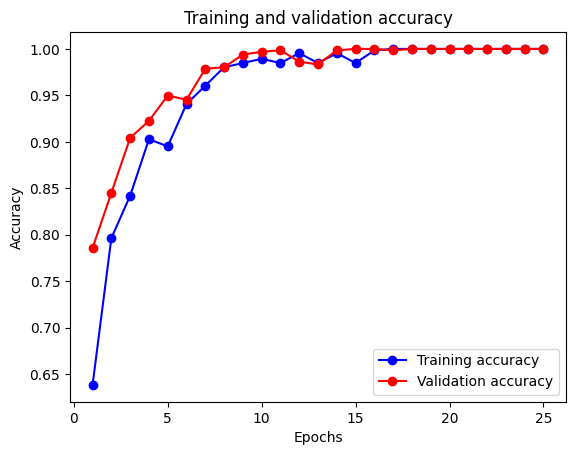

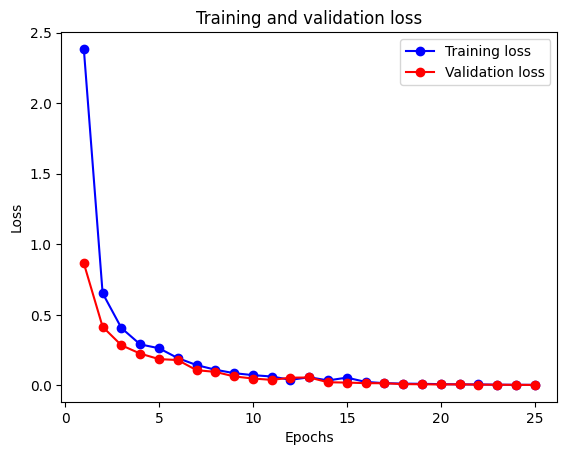

Test Loss: 0.9425206600377957, Test Accuracy: 0.7423312883435583


In [8]:
NN1 = SimpleNN()
optimizer = optim.Adam(NN1.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

train(NN1, optimizer, loss_fn, train_loader, val_loader, epochs=25, device=device)
test(NN1, test_loader, device=device)
